<a href="https://colab.research.google.com/github/dwahast/Deep-learning/blob/master/CNN_MLP_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objetivos deste trabalho
- Familiarizar-se com a biblioteca PyTorch
- Definir arquiteturas MLP simples em PyTorch
- Treinar utilizando CIFAR10, testando diferentes arquiteturas, parâmetros, funções de loss e otimizadores
- Comparar os resultados obtidos utilizando apenas Perpceptrons
- Link útil (https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c)

In [1]:
%matplotlib inline

import numpy as np 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

import torch.nn.functional as F # softmax/relu


import tensorflow as tf #GPU 
from tensorflow.python.client import device_lib

print(tf.test.gpu_device_name())
print(torch.cuda.is_available())


#print(device_lib.list_local_devices())

#import pandas as pd # organize files 


/device:GPU:0
True


In [2]:
# Carregar os datasets

#transform=transforms.Compose([
#    transforms.Grayscale(num_output_channels=1),
#    transforms.ToTensor()
#])

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

#normaliza o dataset de test mas sem data augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

dataset_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

dataset_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform_test)

0it [00:00, ?it/s]

100%|█████████▉| 170369024/170498071 [00:30<00:00, 5630447.64it/s]

Files already downloaded and verified


In [3]:
train_loader = DataLoader(dataset=dataset_train, shuffle=True, batch_size=32)
test_loader = DataLoader(dataset=dataset_test, shuffle=False)
print(len(test_loader))

dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.size())

10000
torch.Size([1, 3, 32, 32])


In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        self.conv_layer = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3,stride=1, padding=1),
          nn.BatchNorm2d(32),   
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Dropout2d(p=0.05),

          nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
          nn.BatchNorm2d(256),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
          )  
        
        self.fc_layers = nn.Sequential(
            
          #Flatten the feature maps. You have 32 feature mapsfrom cnn2. Each of the feature is of size 16x16 --> 32*16*16 = 8192
          nn.Linear(32*32*4, 1024),   #Flattened image is fed into linear NN and reduced to half size
          nn.Dropout(p=0.1),                    #Dropout used to reduce overfitting
          nn.Linear(1024, 512),
          nn.Dropout(p=0.5),
          nn.Linear(512, 256),
          nn.Dropout(p=0.1),
          nn.Linear(256, 96),
          nn.Dropout(p=0.1),
          nn.Linear(96, 10)    #Since there were so many features, I decided to use 45 layers to get output layers. You can increase the kernels in Maxpooling to reduce image further and reduce number of hidden linear layers.

        )
        
    def forward(self,x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [0]:
# Definir a arquitetura MLP

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32*32, 20)
        self.fc2 = nn.Linear(20, 10)
        self.activation_function = nn.Sigmoid()
    def forward(self, x):
        x = x.view(-1, 32*32)
        x = self.activation_function(self.fc1(x))
        x = self.activation_function(self.fc2(x))
        return x
# Arquitecture with RELU      
class MLP_relu(nn.Module):
    def __init__(self):
        super(MLP_relu, self).__init__()
        self.fc1 = nn.Linear(32*32, 20)
        self.fc2 = nn.Linear(20, 10)
    def forward(self, x):
        x = x.view(-1, 32*32)
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x),dim =1)
        return x
      
# New Arquitecture with RELU   
class MLP_Srelu(nn.Module):
    def __init__(self):
        super(MLP_Srelu, self).__init__()
        self.fc1 = nn.Linear(32*32, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 10)
    def forward(self, x):
        x = x.view(-1, 32*32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x),dim =1)
        return x   


In [6]:
model_std = MLP()
model_relu = MLP_relu()
model_Srelu = MLP_Srelu()
model_CNN = CNN()

CUDA = torch.cuda.is_available()
if CUDA:
    model_std = model_std.cuda()
    model_relu = model_relu.cuda()
    model_Srelu = model_Srelu.cuda()
    model_CNN = model_CNN.cuda()
    print("******** CUDA MODEL ENABLE *********\n")

#print(model_CNN)

******** CUDA MODEL ENABLE *********



In [0]:
# Definir otimizador e loss
# Nota: testar outros otimizadores e funções de loss (em particular cross entropy)

def optimizer_set(model,optimizer_method, learning_rate):
  if optimizer_method == "sgd":
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)
  elif optimizer_method == "adadelta":
    optimizer = torch.optim.Adadelta(model.parameters(), lr = learning_rate)
  elif optimizer_method == "adagrad":
    optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)
  elif optimizer_method == "adamax":
    optimizer = torch.optim.Adamax(model.parameters(), lr = learning_rate)
  elif optimizer_method == "adam":
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)  
  elif optimizer_method == "rms":
    optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)
  return optimizer

def loss_function_set(loss_function):
  if loss_function == "mse":
    loss_fn = torch.nn.MSELoss()
  elif loss_function == "nllos":
     loss_fn = torch.nn.NLLoss()
  elif loss_function == "cross":
     loss_fn = torch.nn.CrossEntropyLoss()
  return loss_fn
  

In [0]:
def one_hot(label, output_size):
    
    label_select = np.zeros(output_size)
    label_select[label]=1
    
    return torch.Tensor(label_select)

In [0]:
def evaluate(model, loss_function, dataset):
  model.eval() # set model to Evaluate "mode"
 # losses = []
  corrects = 0
  current_total = 0
  accuracies = 0
  
 # loss_fn = loss_function_set(loss_function)
  
  for image, label in dataset:
    CUDA = torch.cuda.is_available()
    if CUDA:
      image = image.cuda()
      label = label.cuda()
    
    outputs = model(image)
    
   # if(loss_function == 'mse'):
   #   label_target = one_hot(label,10) # one_hot to set the training class in the escalar
   #   loss = loss_fn(outputs,label_target)
   # else:
   #   loss = loss_fn(outputs,label)
      
   # losses.append(loss.item())
    
    _, predicted = torch.max(outputs.data, 1)
    
    if(predicted==label):
      corrects += 1
    
    current_total += 1
  
  accuracy = corrects/current_total

  return accuracy #, np.mean(losses)
      

#Training function

In [0]:
# Realizar o treinamento aqui
def fit(model, epochs, optimizer_method, loss_function, learning_rate):
  
  print("Opt Method:", optimizer_method.upper(), "| Loss Function:", loss_function.upper(), "| Learning Rate:", learning_rate)
  optimizer = optimizer_set(model,optimizer_method, learning_rate) #optimizer and Learning rate setter
  loss_fn = loss_function_set(loss_function) 
  accuracies = []
  losses = []
  train_acc = []
  for epoch in range(epochs):
    model.train() # Set model to TRAIN "mode" (can be set to False for Test)
    epoch_losses = []
    for image,label in train_loader:
      CUDA = torch.cuda.is_available()
      if CUDA:
        image = image.cuda()
        label = label.cuda()
      
      optimizer.zero_grad()  # cleaning gradients between mini batches
      outputs = model(image) 
      
      if(loss_function == 'mse'):
        label_target = one_hot(label,10) # one_hot to set the training class in the escalar
        loss = loss_fn(outputs,label_target)
      else: 
        loss = loss_fn(outputs, label)
        
      loss.backward() # Backpropagation 
      optimizer.step() # Optimization Method
      
      epoch_losses.append(loss.item())

    losses.append(np.mean(epoch_losses)) # Append mean losses for each epoch
   
    
    acc = evaluate(model, loss_function, train_loader)
    train_acc.append(acc)
    acc = evaluate(model, loss_function, test_loader) #evaluate
    accuracies.append(acc)
    
    #if(epoch%10==0):
    print("Epoch:",epoch, "- Average loss:", np.mean(epoch_losses),"- Accuracy:", acc) # Print mean Loss for each epoch
 
  return {
      "Model": outputs,
      "Acc": accuracies,
      "Train Acc": train_acc,
      "Loss": losses,
      "Name": optimizer_method + " | " + loss_function + " | " + str(learning_rate),
      "Arc": model
      #"Evaluate Train Loss": train_losses,
      
  }

# Training Your Model
- Variable "trained_models" append all models trained
- function "fit" train and return the Model and the all variable that will be used latter
  - *fit(Model, Epochs, Optimizer method, Loss function, Learning rate)*

In [11]:
# TREINO ESTOCASTICO
trained_models = []
ep = 50 #epocas
trained_models.append(fit(model_CNN,ep,"adadelta", "cross", 0.001))


Opt Method: ADADELTA | Loss Function: CROSS | Learning Rate: 0.001


170500096it [00:49, 5630447.64it/s]                               

Epoch: 0 - Average loss: 2.106484047811031 - Accuracy: 0.2983
Epoch: 1 - Average loss: 1.7845571892619132 - Accuracy: 0.3456
Epoch: 2 - Average loss: 1.621505954222679 - Accuracy: 0.3843
Epoch: 3 - Average loss: 1.526562838394642 - Accuracy: 0.418
Epoch: 4 - Average loss: 1.4483696310186387 - Accuracy: 0.4107
Epoch: 5 - Average loss: 1.3837930758464336 - Accuracy: 0.449
Epoch: 6 - Average loss: 1.3418473608362675 - Accuracy: 0.4512
Epoch: 7 - Average loss: 1.2967846457147598 - Accuracy: 0.4653
Epoch: 8 - Average loss: 1.2707603407990933 - Accuracy: 0.4779
Epoch: 9 - Average loss: 1.2372692675149441 - Accuracy: 0.482
Epoch: 10 - Average loss: 1.20557392248936 - Accuracy: 0.5079
Epoch: 11 - Average loss: 1.1745548505052925 - Accuracy: 0.5121
Epoch: 12 - Average loss: 1.1553563786216452 - Accuracy: 0.5097
Epoch: 13 - Average loss: 1.1319216933468357 - Accuracy: 0.5067
Epoch: 14 - Average loss: 1.1117733499684557 - Accuracy: 0.539
Epoch: 15 - Average loss: 1.0894200545607506 - Accuracy: 0.

# Text and Graphical Output

In [0]:
def graphical_outputs(trained_models):
  plt.title("\n\nAccuracy " + trained_models[0]["Name"].upper() +"\n", fontsize=20, loc="left")
  plt.title("dotted line = train")
  for models in trained_models:
    plt.plot(models["Acc"], label = str(models["Arc"]).partition("(")[0])
    plt.plot(models["Train Acc"],"--") 
    print(models["Arc"],"\n", "ACC: ", np.mean(models["Acc"]),"\n")

  plt.legend(loc='best')
  plt.show


CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout2d(p=0.05)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU(inplace)
   

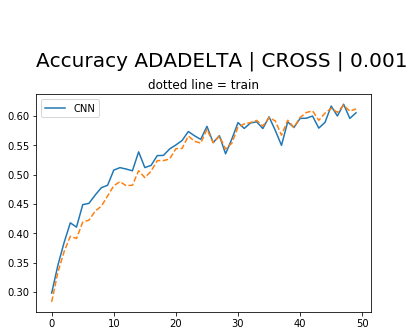

In [13]:
graphical_outputs(trained_models)

In [0]:
# TREINO ESTOCASTICO
#trained_models1 = [] #Model com batch
#model_CNN = CNN()
#train_loader = DataLoader(dataset=dataset_train, shuffle=True, batch_size =32)
#ep = 50 #epocas
#trained_models1.append(fit(model_CNN,ep,"adadelta", "cross", 0.001))

In [0]:
#graphical_outputs(trained_models1)